In [61]:
%matplotlib inline
#!pip3 install pytesseract
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import math
import pytesseract
import re

from functools import partial
import concurrent.futures

In [114]:
%run four_point_transform.py
%run cv_utils/cv_utils.py

In [73]:
def match_int(s):
    match = re.match('\d+', s)
    if match is None:
        return 0
    return int(match.group(0))

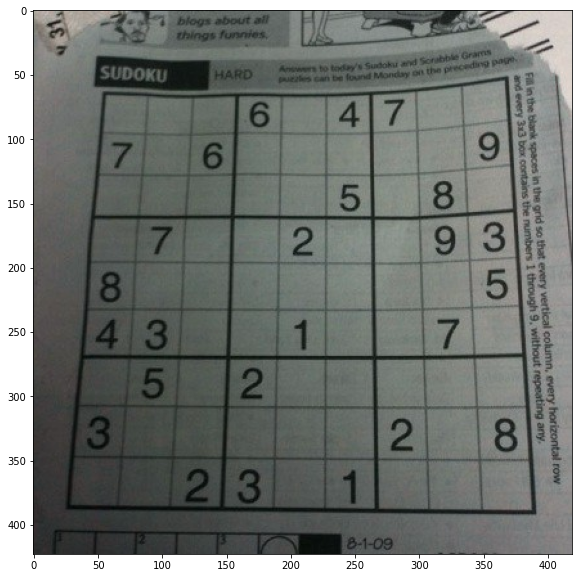

In [228]:
src = 'sudoku.jpeg'
# src = 'sudoku_1.png'
# src = 'sudoku_2.png'
# src = 'sudoku_3.png'

img = cv.imread(src)

draw(img)

In [229]:
class Pipeline:
    def __init__(self, pipelines):
        self.pipelines = pipelines
    def exec(self, src):
        dst = src.copy()
        self.steps = {}
        for name, fn in self.pipelines:
            dst = fn(dst)
            self.steps[name] = dst.copy()
        return dst

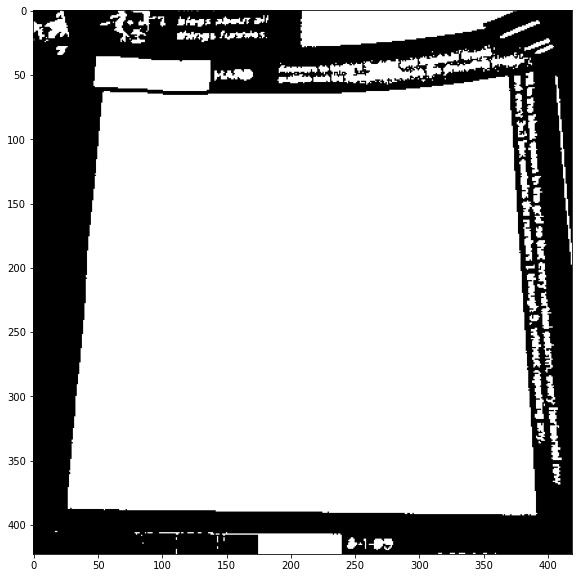

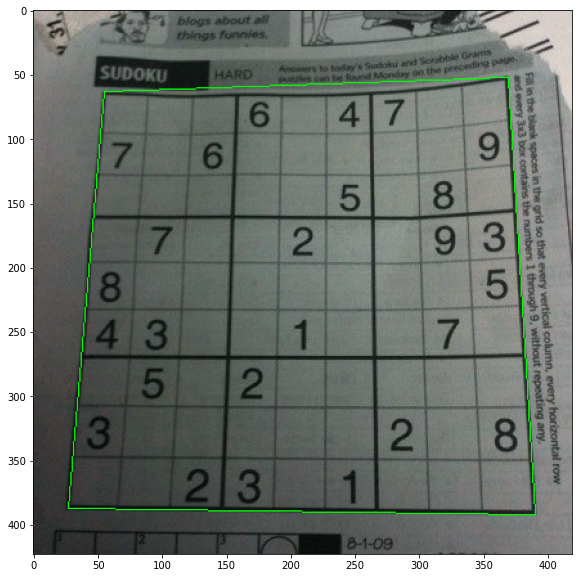

In [230]:
height, width = img.shape[:2]

# Assuming user takes the full photo of sudoku - so the whole grid fits into
# the picture. Since it's a square, take the minimum dimension. 
# Assume that the box fit to at least 80% of the image (the Pareto's Principle).
dim = min(height, width) * 0.8


# Divide it by 9 since one row/column will have 9 cells. 
# Use that as the kernel size.
cell = int(dim / 9) # Equivalent to math.ceil.

pipeline = Pipeline([('gray', Gray),
                     ('inverse', Inverse),
#                      ('blur', MedianBlur),
                     # We want to use tophat to capture only the grid - 
                     # anything larger than it will be excluded.
                     ('tophat', partial(TopHat, size=(cell, cell))),
                     ('thresh', Otsu),
                     ('floodfill', partial(FloodFill, color=255))
                    ])

dst = pipeline.exec(img)
draw(dst)
# Find the largest contour on the image. This represents the sudoku main grid.
cnt = FindOuterContour(dst)
DrawContour(img, [cnt])

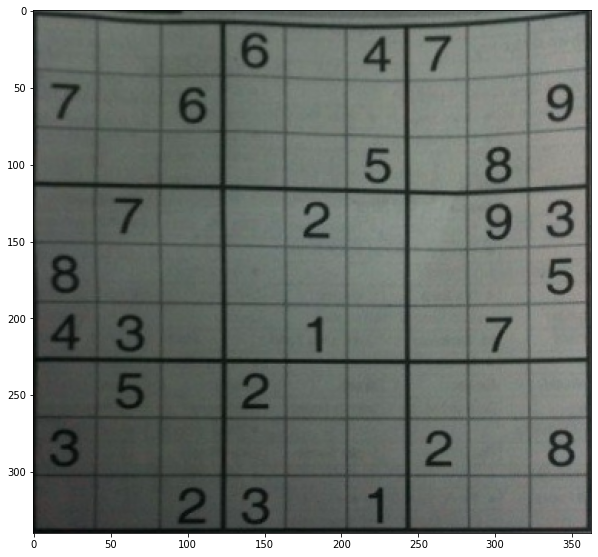

In [231]:
# The image may be skewed, we will correct it.
transform = four_point_transform(img.copy(), cnt.reshape(4, 2))
draw(transform)

In [232]:
height, width = transform.shape[:2]
cell_height, cell_width = height//9, width//9
offset_height, offset_width = cell_height // 5, cell_width // 5
dim = min(cell_width, cell_height)

sudoku = np.zeros((9, 9), int)

# Get the image from left to right, top to bottom.
for i in range (0, 9):
    for j in range (0, 9):
        # We do not take the extra square, but instead allow padding of 20% on the left, right, top and bottom.
        y0, y1 = max(i * cell_height - offset_height, 0), min((i+1) * cell_height + offset_height, height)
        x0, x1 = max(j * cell_width - offset_width, 0), min((j+1) * cell_width + offset_width, width)
        
        pipe = Pipeline([
            ('gray', Gray),
            ('blur', partial(MedianBlur, size=3)),
            ('thresh', Otsu)
        ])
        # Note that height comes before width.
        im_thresh = pipe.exec(transform[y0:y1, x0:x1])
        cnt = FindOuterContour(im_thresh)
#         DrawContour(im_thresh, [cnt])
#         draw(im_thresh)
        if cnt is None:
            im_roi = im_thresh
        else:
            im_roi = ExtractContourRegionOfInterest(im_thresh, cnt)
#         draw(im_roi)
        try:
            text = pytesseract.image_to_string(im_roi, config='--oem 1 --psm 6') # Needs to be enabled to read single digit.
            sudoku[i, j] = match_int(text)
        except:
            continue
sudoku

array([[0, 0, 0, 6, 0, 4, 7, 0, 0],
       [7, 0, 6, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 0, 0, 5, 0, 8, 0],
       [0, 7, 0, 0, 2, 0, 0, 9, 3],
       [0, 0, 0, 0, 0, 7, 0, 0, 5],
       [0, 3, 0, 0, 1, 0, 0, 7, 0],
       [0, 5, 0, 2, 0, 0, 0, 0, 0],
       [3, 1, 0, 0, 0, 1, 2, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0, 0]])

In [210]:
%run sudoku.py

<Figure size 432x288 with 0 Axes>

In [234]:
solver = SudokuSolver()
result = solver(sudoku)
print(result)

None


In [235]:
font = cv.FONT_HERSHEY_SIMPLEX

color = (0, 255, 0) 
thickness = 3

def get_optimal_font_scale(text, width):
    for scale in reversed(range(0, 60, 1)):
        textSize = cv.getTextSize(text, fontFace=cv.FONT_HERSHEY_DUPLEX, fontScale=scale/10, thickness=1)
        new_width = textSize[0][0]
        if (new_width <= width):
            return scale/10
    return 1


gb = cv.bitwise_not(Gray(transform))
out = cv.cvtColor(gb, cv.COLOR_GRAY2RGB)

height, width = transform.shape[:2]
cell_height, cell_width = height // 9, width // 9

for i in range(0, 9):
    for j in range(0, 9):
        org = (cell_width * i, cell_height * (j+1))
        text = str(int(result[j, i]))
        font_scale = get_optimal_font_scale(text, cell_width)
        if sudoku[j, i] == 0:
            out = cv.putText(out, text, org, font, font_scale, color, thickness, cv.LINE_AA) 
        else:
            out = cv.putText(out, text, org, font, font_scale, (255, 0, 0), thickness, cv.LINE_AA) 
draw(out)

TypeError: 'NoneType' object is not subscriptable